In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt

epochs = 10
lr_sgd = 0.01
lr_adam = 0.0001

In [8]:
class Net(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)  # Return just the mean of the losses

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
device = torch.device("cuda") # to use the GPU
batch_size = 64

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)



## Exercise 0
Create a plot of the values of the training/test losses and training accuracies/test.

This can help to monitor how the training is going.

In [12]:
def train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name, scheduler=None, title = 'Training and Testing Loss Over Epochs'):
    train_loss = []
    test_loss = []
    epoch_list = []
    epoch_times = []  # Track times for each epoch

    overall_start_time = time.time()  # Start overall timer

    for epoch in range(1, epochs + 1):
        start_time = time.time()  # Start timer for the epoch
        
        epoch_list.append(epoch)
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        end_time = time.time()  # End timer for the epoch

        # Update the learning rate if using a scheduler
        if scheduler:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}, Learning Rate: {current_lr:.6f}")
        else:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}, Learning Rate: {current_lr:.6f}")
        
        test_l, _ = test(model, device, test_loader)
        test_loss.append(test_l)
        
        epoch_times.append(end_time - start_time)  # Record time for the epoch
        
    overall_end_time = time.time()  # End overall timer
    total_execution_time = overall_end_time - overall_start_time  # Calculate total time
    total_training_time = np.sum(epoch_times)  # Total training time
    avg_epoch_time = np.mean(epoch_times)  # Average time per epoch

    # Create a smaller figure
    plt.figure(figsize=(6, 4))  # Adjust the size as needed

    # Loss plot
    plt.plot(epoch_list, train_loss, label='Train Loss', color='#1f77b4', linewidth=1.5, marker='o', markersize=3)
    plt.plot(epoch_list, test_loss, label='Test Loss', color='#ff7f0e', linewidth=1.5, marker='s', markersize=3)

    plt.title(title, fontsize=10)
    plt.xlabel('Epoch', fontsize=9)
    plt.ylabel('Loss', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid
    plt.legend(loc='upper right', fontsize=8)

    # Tight layout ensures the plot doesn't overlap
    plt.tight_layout()

    # Save the plot with a specific file name
    plt.savefig(f"plot_assignment/{save_name}.png", dpi=300, bbox_inches='tight')  # Save as PNG with high DPI

    # Show the plot
    plt.show()

    # Print the total and average epoch time with enhanced formatting
    print("="*40)
    print(f" Total Execution Time: {total_execution_time:.2f} seconds")
    print(f" Total Training Time: {total_training_time:.2f} seconds")
    print(f" Average Time per Epoch: {avg_epoch_time:.2f} seconds")
    print("="*40)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306489
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.280056
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.2052, Accuracy: 9394/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.257890
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.084627
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.1316, Accuracy: 9607/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.102675
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.066498
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.1178, Accuracy: 9645/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.129029
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.096981
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.1148, Accuracy: 9646/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.128836
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.128106
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0718, Accuracy: 9780/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.043924
Train Epoc

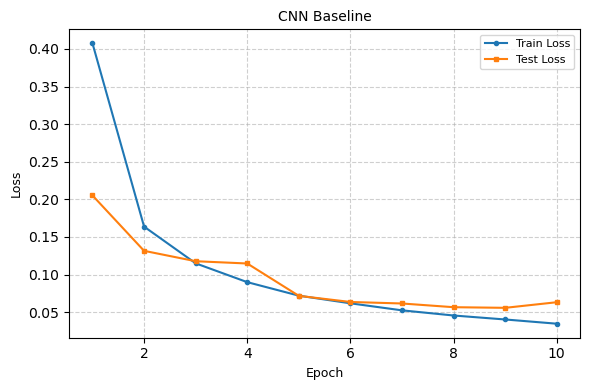

 Total Execution Time: 128.88 seconds
 Total Training Time: 93.34 seconds
 Average Time per Epoch: 9.33 seconds


In [13]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='given_cnn.png', title = 'CNN Baseline')

## Exercise 1

Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding)

How the performance change? Why?

# Fully Connected

I start with a small fully connected with 3 layers

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317771
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.396454
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.3511, Accuracy: 8993/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.323290
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.494931
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.2735, Accuracy: 9200/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.207836
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.247125
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.2423, Accuracy: 9304/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.271158
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.110014
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.2078, Accuracy: 9401/10000 (94%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.314429
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.174337
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.1845, Accuracy: 9455/10000 (95%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.208298
Train Epoc

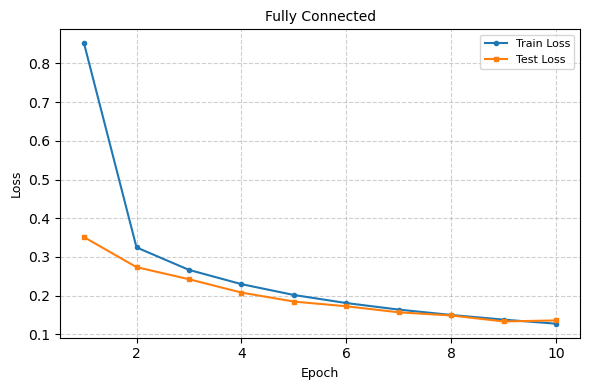

 Total Execution Time: 115.84 seconds
 Total Training Time: 81.61 seconds
 Average Time per Epoch: 8.16 seconds


In [14]:

class SmallFullyConnectedNet(nn.Module):
    def __init__(self):
        super(SmallFullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(784, 64)  # First layer: Input 784, output 64
        self.fc2 = nn.Linear(64, 32)   # Second layer: Input 64, output 32
        self.fc3 = nn.Linear(32, 10)   # Third layer: Input 32, output 10 (classes)
        
    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input from (B, 1, 28, 28) to (B, 784)
        x = F.relu(self.fc1(x))  # Apply ReLU after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU after second layer
        x = self.fc3(x)          # Output layer, no activation function (we'll use softmax outside)
        return F.log_softmax(x, dim=1)  # Use log_softmax for classification


model = SmallFullyConnectedNet().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='small_fc.png', title = 'Fully Connected')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293190
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.553167
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.2911, Accuracy: 9360/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.286390
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.164566
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.1790, Accuracy: 9566/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.217308
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.204487
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.1377, Accuracy: 9650/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.106502
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.136531
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.1178, Accuracy: 9701/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.071972
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.176051
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.1085, Accuracy: 9696/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.085399
Train Epoc

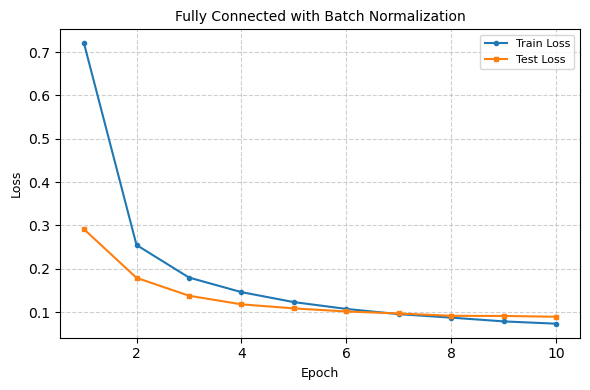

 Total Execution Time: 122.81 seconds
 Total Training Time: 85.84 seconds
 Average Time per Epoch: 8.58 seconds


In [15]:
class Small_Linear_Normalized(nn.Module):
    def __init__(self):
        super(Small_Linear_Normalized, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(784, 64)  # First layer: Input 784, output 64
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization for the first layer
        
        self.fc2 = nn.Linear(64, 32)   # Second layer: Input 64, output 32
        self.bn2 = nn.BatchNorm1d(32)  # Batch normalization for the second layer
        
        self.fc3 = nn.Linear(32, 10)   # Third layer: Input 32, output 10 (classes)

    def forward(self, x):
        x = torch.flatten(x, 1)        # Flatten the input from (B, 1, 28, 28) to (B, 784)
        
        # First layer with batch normalization and ReLU activation
        x = self.fc1(x)
        x = self.bn1(x)                # Apply batch normalization
        x = F.relu(x)                  # Apply ReLU
        
        # Second layer with batch normalization and ReLU activation
        x = self.fc2(x)
        x = self.bn2(x)                # Apply batch normalization
        x = F.relu(x)                  # Apply ReLU
        
        # Output layer without batch normalization
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1) # Use log_softmax for classification

# Initialize model, optimizer, and run training and testing
model = Small_Linear_Normalized().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='small_normalized.png', title = 'Fully Connected with Batch Normalization')


CNN scores are a little better that Fully Connected even time of execution.

In general a CNN works better because a fully connected does not focus on local features of the image.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308457
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.694678
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.3569, Accuracy: 8980/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.403975
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.276482
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.2611, Accuracy: 9235/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.390838
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.114156
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.2111, Accuracy: 9383/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.278406
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.152441
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.1730, Accuracy: 9478/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.174390
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.245240
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.1442, Accuracy: 9573/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.102777
Train Epoc

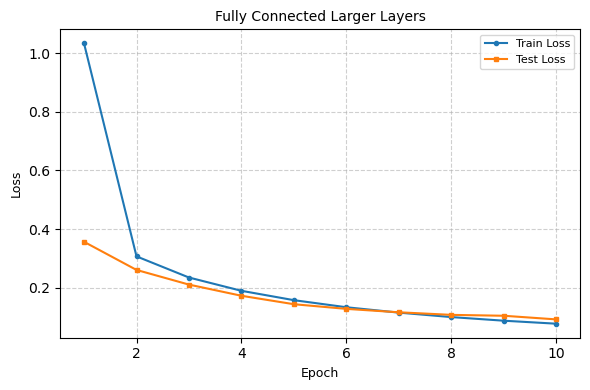

 Total Execution Time: 123.26 seconds
 Total Training Time: 86.51 seconds
 Average Time per Epoch: 8.65 seconds


In [16]:
class Net_Larger_FC(nn.Module):
    def __init__(self):
        super(Net_Larger_FC, self).__init__()
        
        # Increase the size of the hidden layers
        self.fc1 = nn.Linear(784, 1024)  # First layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 512)    # Second layer with 512 neurons
        self.fc3 = nn.Linear(512, 256)     # Third layer with 256 neurons
        self.fc4 = nn.Linear(256, 10)      # Output layer with 10 neurons for 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the image to a 1D vector
        
        # Pass through fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Output layer with log_softmax activation for classification
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
model = Net_Larger_FC().to(device)

optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='larger_fc.png', title = 'Fully Connected Larger Layers')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.402340
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.258333
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1319, Accuracy: 9639/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.227426
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.073348
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0917, Accuracy: 9729/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.102153
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.030907
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0754, Accuracy: 9771/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.031631
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.040246
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0709, Accuracy: 9777/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011897
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.007537
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0646, Accuracy: 9801/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.014651
Train Epoc

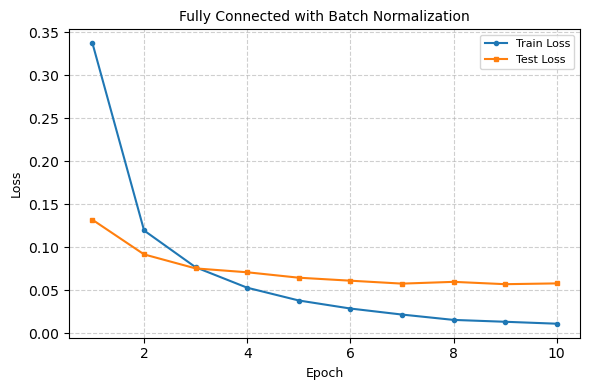

 Total Execution Time: 121.60 seconds
 Total Training Time: 84.94 seconds
 Average Time per Epoch: 8.49 seconds


In [17]:
class Net_Larger_FC_Normalized(nn.Module):
    def __init__(self):
        super(Net_Larger_FC_Normalized, self).__init__()
        
        # Increase the size of the hidden layers
        self.fc1 = nn.Linear(784, 1024)    # First layer with 1024 neurons
        self.bn1 = nn.BatchNorm1d(1024)    # Batch normalization for the first layer
        
        self.fc2 = nn.Linear(1024, 512)    # Second layer with 512 neurons
        self.bn2 = nn.BatchNorm1d(512)     # Batch normalization for the second layer
        
        self.fc3 = nn.Linear(512, 256)     # Third layer with 256 neurons
        self.bn3 = nn.BatchNorm1d(256)     # Batch normalization for the third layer
        
        self.fc4 = nn.Linear(256, 10)      # Output layer with 10 neurons for 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the image to a 1D vector
        
        # Pass through fully connected layers with batch normalization and ReLU activation
        x = F.relu(self.bn1(self.fc1(x)))  # First layer + batch norm + ReLU
        x = F.relu(self.bn2(self.fc2(x)))  # Second layer + batch norm + ReLU
        x = F.relu(self.bn3(self.fc3(x)))  # Third layer + batch norm + ReLU
        
        # Output layer with log_softmax activation for classification
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
# Initialize model, optimizer, and run training and testing
model = Net_Larger_FC_Normalized().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='larger_fc_normalized.png', title = 'Fully Connected with Batch Normalization')


Now i create a depper version with similar number of parameters. The large one has 1,462,538 parameters, this deeper one has 1,446,082 so not exactly the same but we have a similar number

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.433689
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.323096
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1705, Accuracy: 9628/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.181484
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.283849
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.1186, Accuracy: 9703/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.100851
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.145295
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0916, Accuracy: 9769/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022281
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.050446
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0880, Accuracy: 9774/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.124762
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.009697
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0810, Accuracy: 9780/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.060297
Train Epoc

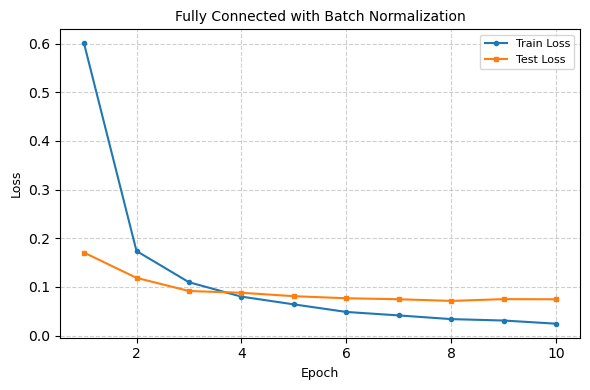

 Total Execution Time: 128.14 seconds
 Total Training Time: 91.51 seconds
 Average Time per Epoch: 9.15 seconds


In [18]:
class Net_Deeper(nn.Module):
    def __init__(self):
        super(Net_Deeper, self).__init__()
        
        # Architecture with 11 layers and batch normalization
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for fc1
        
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)  # Batch normalization for fc2
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization for fc3
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)  # Batch normalization for fc4
        
        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)  # Batch normalization for fc5
        
        self.fc6 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)  # Batch normalization for fc6
        
        self.fc7 = nn.Linear(512, 128)
        self.bn7 = nn.BatchNorm1d(128)  # Batch normalization for fc7
        
        self.fc8 = nn.Linear(128, 128)
        self.bn8 = nn.BatchNorm1d(128)  # Batch normalization for fc8
        
        self.fc9 = nn.Linear(128, 64)
        self.bn9 = nn.BatchNorm1d(64)   # Batch normalization for fc9
        
        self.fc10 = nn.Linear(64, 32)
        self.bn10 = nn.BatchNorm1d(32)  # Batch normalization for fc10
        
        self.fc11 = nn.Linear(32, 10)   # Output layer

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        # Passing through fully connected layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = F.relu(self.bn8(self.fc8(x)))
        x = F.relu(self.bn9(self.fc9(x)))
        x = F.relu(self.bn10(self.fc10(x)))
        
        # Output layer with log_softmax for classification
        x = F.log_softmax(self.fc11(x), dim=1)
        return x
    
# Initialize model, optimizer, and run training and testing
model = Net_Deeper().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='deeper.png', title = 'Fully Connected with Batch Normalization')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.262101
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.126007
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1098, Accuracy: 9742/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.057193
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.106528
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0816, Accuracy: 9785/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.037566
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.193999
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0712, Accuracy: 9799/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022514
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.028302
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0686, Accuracy: 9808/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.031202
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.017434
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0727, Accuracy: 9799/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.011452
Train Epoc

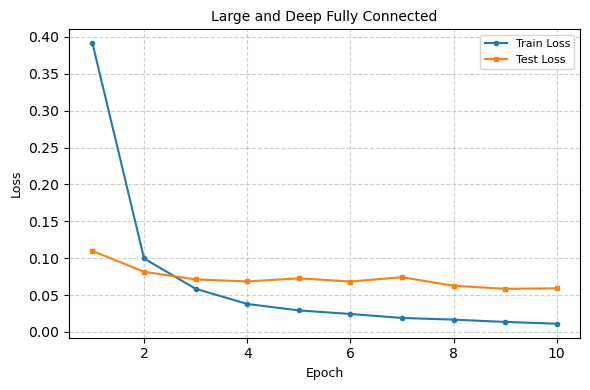

 Total Execution Time: 130.44 seconds
 Total Training Time: 93.17 seconds
 Average Time per Epoch: 9.32 seconds


In [19]:
class Net_Deeper_Large(nn.Module):
    def __init__(self):
        super(Net_Deeper_Large, self).__init__()
        
        # Increase the sizes of each layer significantly
        self.fc1 = nn.Linear(28*28, 2048)
        self.bn1 = nn.BatchNorm1d(2048)  # Batch normalization layer
        
        self.fc2 = nn.Linear(2048, 2048)
        self.bn2 = nn.BatchNorm1d(2048)  # Batch normalization layer
        
        self.fc3 = nn.Linear(2048, 2048)
        self.bn3 = nn.BatchNorm1d(2048)  # Batch normalization layer
        
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)  # Batch normalization layer
        
        self.fc5 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)  # Batch normalization layer
        
        self.fc6 = nn.Linear(1024, 512)
        self.bn6 = nn.BatchNorm1d(512)  # Batch normalization layer
        
        self.fc7 = nn.Linear(512, 512)
        self.bn7 = nn.BatchNorm1d(512)  # Batch normalization layer
        
        self.fc8 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)  # Batch normalization layer
        
        self.fc9 = nn.Linear(256, 128)
        self.bn9 = nn.BatchNorm1d(128)  # Batch normalization layer
        
        self.fc10 = nn.Linear(128, 64)
        self.bn10 = nn.BatchNorm1d(64)  # Batch normalization layer
        
        self.fc11 = nn.Linear(64, 10)  # Output layer (no batch norm)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = F.relu(self.bn8(self.fc8(x)))
        x = F.relu(self.bn9(self.fc9(x)))
        x = F.relu(self.bn10(self.fc10(x)))
        x = F.log_softmax(self.fc11(x), dim=1)
        return x

    
model = Net_Deeper_Large().to(device)

optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='deeper_large.png', title = 'Large and Deep Fully Connected')

Here the number of parameters increased a lot and clearly i would say that the performances are better with a little slower time execution

# CNN with avg and maxpoolimg

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291275
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.360300
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.2965, Accuracy: 9144/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.345640
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.180670
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.2123, Accuracy: 9397/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.220882
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.128651
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.1515, Accuracy: 9544/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.131884
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.131328
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.1398, Accuracy: 9545/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.138306
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.051866
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.1100, Accuracy: 9669/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.113522
Train Epoc

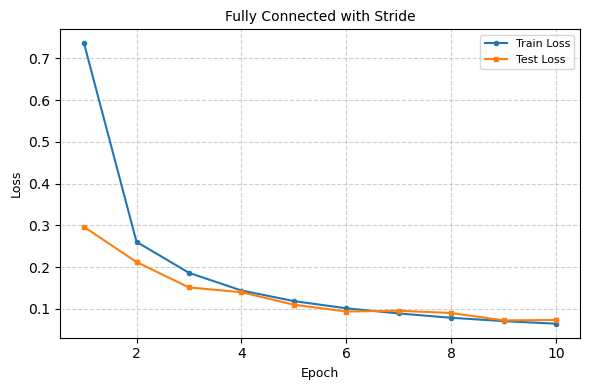

 Total Execution Time: 128.40 seconds
 Total Training Time: 92.29 seconds
 Average Time per Epoch: 9.23 seconds


In [20]:
class Net_With_Stride(nn.Module):
    def __init__(self):
        super(Net_With_Stride, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2)  # Stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 2)  # Stride of 1
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution layer 1 with stride 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # Convolution layer 2 with stride 1
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling with kernel size 2
        
        # Flattening and fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Log-softmax for classification output
        output = F.log_softmax(x, dim=1)
        return output


model = Net_With_Stride().to(device)


optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='stride.png', title = 'Fully Connected with Stride')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310180
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.302620
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1872, Accuracy: 9453/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.176145
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.157893
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.1533, Accuracy: 9518/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.151179
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.312621
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.1512, Accuracy: 9532/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.212326
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.119449
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.1128, Accuracy: 9646/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.165361
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.064840
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.2487, Accuracy: 9267/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.346881
Train Epoc

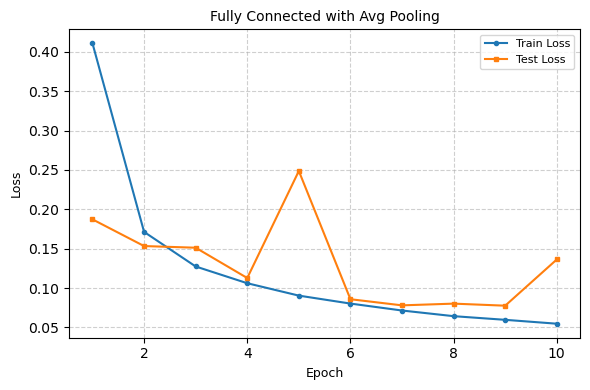

 Total Execution Time: 131.29 seconds
 Total Training Time: 94.46 seconds
 Average Time per Epoch: 9.45 seconds


In [21]:
class Net_With_AvgPooling(nn.Module):
    def __init__(self):
        super(Net_With_AvgPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # Stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # Stride of 1
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution layer 1 with stride 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # Convolution layer 2 with stride 1
        x = self.conv2(x)
        x = F.relu(x)
        
        # Avg pooling with kernel size 2
        x = F.avg_pool2d(x, 2)
        
        # Flattening and fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Log-softmax for classification output
        output = F.log_softmax(x, dim=1)
        return output

model = Net_With_AvgPooling().to(device)


optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='avg_pooling.png', title = 'Fully Connected with Avg Pooling')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308587
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.175318
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1364, Accuracy: 9616/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.115007
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.048189
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0788, Accuracy: 9742/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.098061
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.046079
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0624, Accuracy: 9809/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.037541
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.100465
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0509, Accuracy: 9826/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.034229
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.018100
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0484, Accuracy: 9845/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.008013
Train Epoc

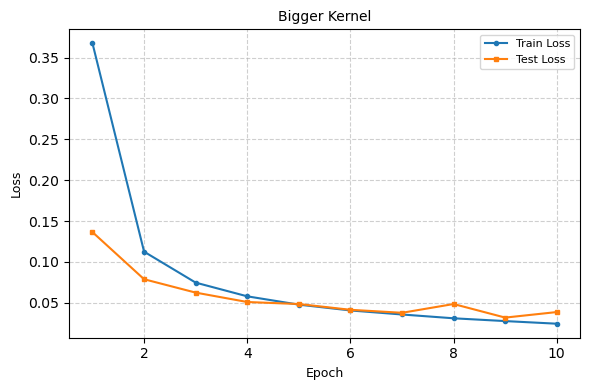

 Total Execution Time: 134.73 seconds
 Total Training Time: 96.80 seconds
 Average Time per Epoch: 9.68 seconds


In [22]:
class Net_bigger_kernels(nn.Module):
    def __init__(self):
        """ 
        from torch.docs
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                        groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_bigger_kernels, self).__init__()
        
        # Increased kernel size from 3x3 to 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6400, 128)  # Adjusted input size due to larger kernels
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, C, H, W
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output

# Initialize the model and optimizer
model = Net_bigger_kernels().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='bigger_kernels.png', title = 'Bigger Kernel')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296354
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.202956
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1184, Accuracy: 9653/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.154772
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.064545
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0691, Accuracy: 9783/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.029466
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.019260
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0709, Accuracy: 9779/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.064009
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.052229
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0452, Accuracy: 9852/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.032062
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.015948
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0415, Accuracy: 9868/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.029743
Train Epoc

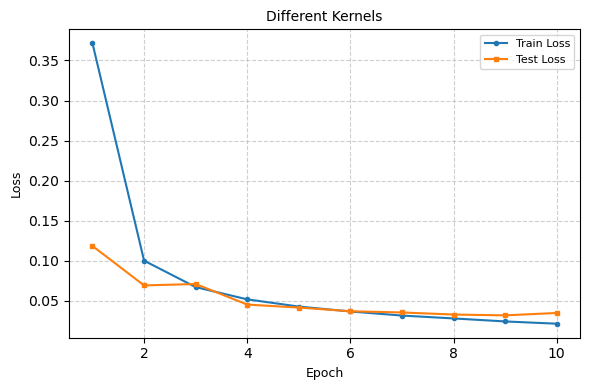

 Total Execution Time: 128.32 seconds
 Total Training Time: 91.19 seconds
 Average Time per Epoch: 9.12 seconds


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Increased kernel sizes
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)  # Output: 26 x 26 x 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9, stride=1)  # Output: 18 x 18 x 64
        
        # Max pooling reduces size from 18x18 to 9x9
        self.fc1 = nn.Linear(64 * 9 * 9, 128)  # Input size adjusted to 5184
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)  # Reduces to 9 x 9 x 64
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output

# Initialize the model and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Ensure you're using the correct device
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Adjust learning rate as necessary

# Run training and testing
# Ensure you have defined train_test_plot and the required data loaders
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='different_kernels.png', title = 'Different Kernels')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316542
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.091109
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1380, Accuracy: 9581/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.237645
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.092017
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0771, Accuracy: 9760/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.147273
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.098090
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0547, Accuracy: 9824/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.113123
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.020558
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0434, Accuracy: 9860/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.020423
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.045666
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0412, Accuracy: 9858/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.177897
Train Epoc

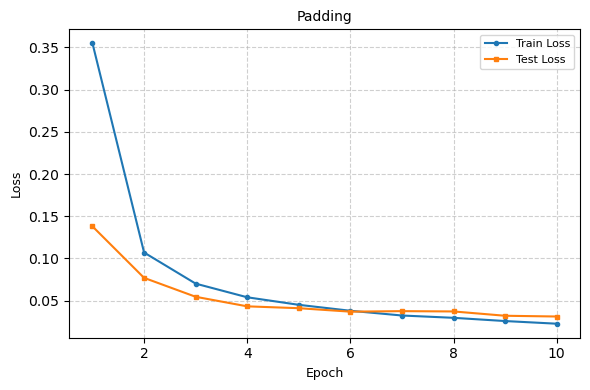

 Total Execution Time: 130.79 seconds
 Total Training Time: 93.88 seconds
 Average Time per Epoch: 9.39 seconds


In [24]:
class Net_padding(nn.Module):
    def __init__(self):
        """ 
        from torch.docs
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                        groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_padding, self).__init__()
        
        # Increased kernel size from 3x3 to 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, padding_mode='reflect')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, padding_mode='reflect')
        
        # Fully connected layers
        self.fc1 = nn.Linear(12544, 128)  # Adjusted input size due to larger kernels
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, C, H, W
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output

# Initialize the model and optimizer
model = Net_padding().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='padding.png', title = 'Padding')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304774
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.361391
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1749, Accuracy: 9521/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.103793
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.076435
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.1081, Accuracy: 9686/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.130163
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.042895
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0840, Accuracy: 9733/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.146194
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.103865
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0621, Accuracy: 9801/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.101708
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.203824
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0707, Accuracy: 9764/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.154854
Train Epoc

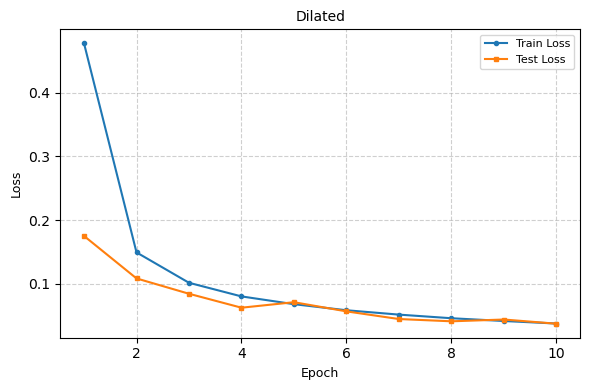

 Total Execution Time: 132.14 seconds
 Total Training Time: 95.38 seconds
 Average Time per Epoch: 9.54 seconds


In [25]:
class Net_dilated(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_dilated, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1,dilation=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1,dilation=2)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    
# Initialize the model and optimizer
model = Net_dilated().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='dilated.png', title = 'Dilated')



## Exercise 2

Try to work with the hyperparameters (batch_size, learning_rate, ...).

In particular try to focus on the optimization part. Change algorithm, momentum, parameters...

Please refer to https://pytorch.org/docs/stable/optim.html to see how to set all the parameters

How can it be improved?

Here the

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294976
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089056
Epoch 1, Learning Rate: 0.100000

Test set: Average loss: 0.0455, Accuracy: 9855/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.069165
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.020121
Epoch 2, Learning Rate: 0.100000

Test set: Average loss: 0.0362, Accuracy: 9887/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.006135
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.032614
Epoch 3, Learning Rate: 0.100000

Test set: Average loss: 0.0300, Accuracy: 9901/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.064512
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.007861
Epoch 4, Learning Rate: 0.100000

Test set: Average loss: 0.0344, Accuracy: 9893/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.086634
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.015500
Epoch 5, Learning Rate: 0.100000

Test set: Average loss: 0.0322, Accuracy: 9900/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.006101
Train Epoc

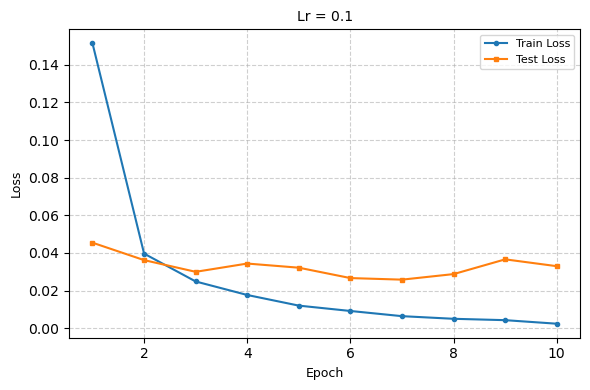

 Total Execution Time: 136.80 seconds
 Total Training Time: 99.45 seconds
 Average Time per Epoch: 9.94 seconds


In [26]:
model = Net().to(device)    

optimizer = optim.SGD(model.parameters(), 0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='01.png', title = 'Lr = 0.1')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315367
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.252059
Epoch 1, Learning Rate: 0.000100

Test set: Average loss: 2.1688, Accuracy: 5261/10000 (53%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.177428
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.033590
Epoch 2, Learning Rate: 0.000100

Test set: Average loss: 1.9169, Accuracy: 6597/10000 (66%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.949915
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.744863
Epoch 3, Learning Rate: 0.000100

Test set: Average loss: 1.4932, Accuracy: 7449/10000 (74%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.369980
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.356508
Epoch 4, Learning Rate: 0.000100

Test set: Average loss: 1.0478, Accuracy: 8041/10000 (80%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.933780
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.877473
Epoch 5, Learning Rate: 0.000100

Test set: Average loss: 0.7646, Accuracy: 8378/10000 (84%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.708252
Train Epoc

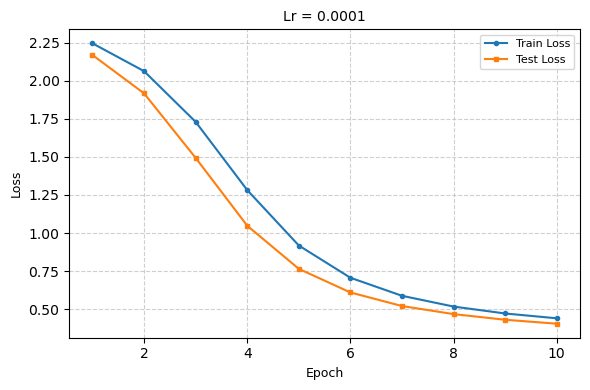

 Total Execution Time: 133.44 seconds
 Total Training Time: 97.19 seconds
 Average Time per Epoch: 9.72 seconds


In [27]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.0001)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='0001.png', title = 'Lr = 0.0001')

# With momentum

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303888
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.037759
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.0435, Accuracy: 9838/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.064376
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.061524
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0373, Accuracy: 9871/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.010037
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.004999
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0278, Accuracy: 9906/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.005060
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.004210
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0297, Accuracy: 9899/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003030
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.092247
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0309, Accuracy: 9898/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.046796
Train Epoc

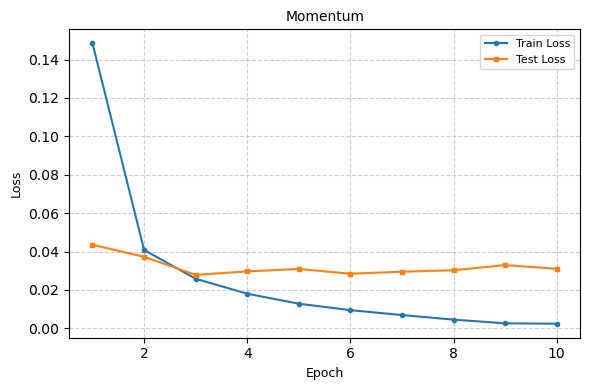

 Total Execution Time: 129.87 seconds
 Total Training Time: 94.33 seconds
 Average Time per Epoch: 9.43 seconds


In [28]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='momentum.png', title = 'Momentum')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291559
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.099499
Epoch 1, Learning Rate: 0.000100

Test set: Average loss: 0.0676, Accuracy: 9773/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.071032
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.014492
Epoch 2, Learning Rate: 0.000100

Test set: Average loss: 0.0447, Accuracy: 9865/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.047114
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.012663
Epoch 3, Learning Rate: 0.000100

Test set: Average loss: 0.0371, Accuracy: 9867/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.033025
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.076490
Epoch 4, Learning Rate: 0.000100

Test set: Average loss: 0.0343, Accuracy: 9887/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.004392
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.018380
Epoch 5, Learning Rate: 0.000100

Test set: Average loss: 0.0295, Accuracy: 9906/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.068473
Train Epoc

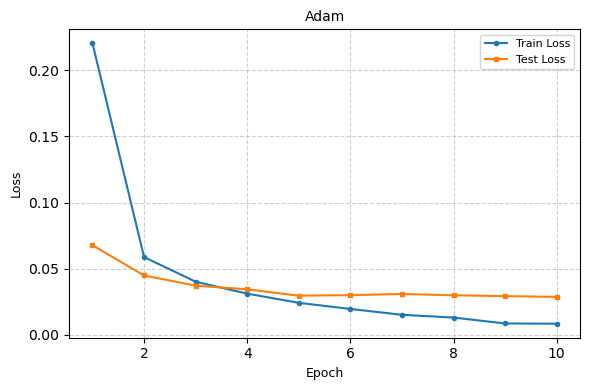

 Total Execution Time: 128.17 seconds
 Total Training Time: 93.17 seconds
 Average Time per Epoch: 9.32 seconds


In [29]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), 0.0001)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='adam.png', title = 'Adam')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307421
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.011179
Epoch 1, Learning Rate: 0.100000

Test set: Average loss: 0.0523, Accuracy: 9828/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.184922
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.109875
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0425, Accuracy: 9863/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.005313
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000628
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0267, Accuracy: 9908/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.042566
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.043795
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.015022
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.109302
Epoch 5, Learning Rate: 0.001000

Test set: Average loss: 0.0255, Accuracy: 9914/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.040868
Train Epoc

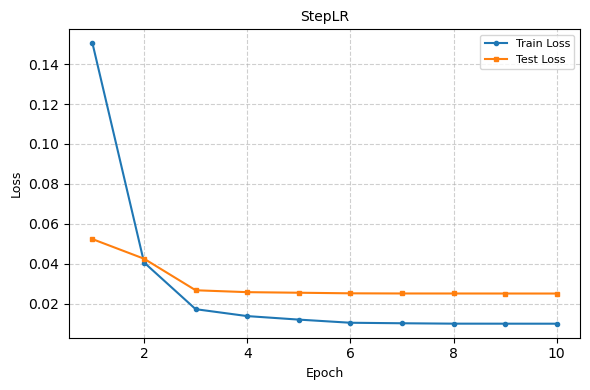

 Total Execution Time: 131.87 seconds
 Total Training Time: 95.85 seconds
 Average Time per Epoch: 9.59 seconds


In [30]:
# Example usage with StepLR scheduler
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 5, 7], gamma=0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs=10, scheduler=scheduler, save_name='stepLR.png', title = 'StepLR')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296545
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.430038
Epoch 1, Learning Rate: 0.100000

Test set: Average loss: 2.3055, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.304563
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.315210
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 2.3057, Accuracy: 1028/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.295307
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.302691
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.307018
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.302335
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 2.3017, Accuracy: 1135/10000 (11%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.310627
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.302078
Epoch 5, Learning Rate: 0.001000

Test set: Average loss: 2.3012, Accuracy: 1135/10000 (11%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.290373
Train Epoc

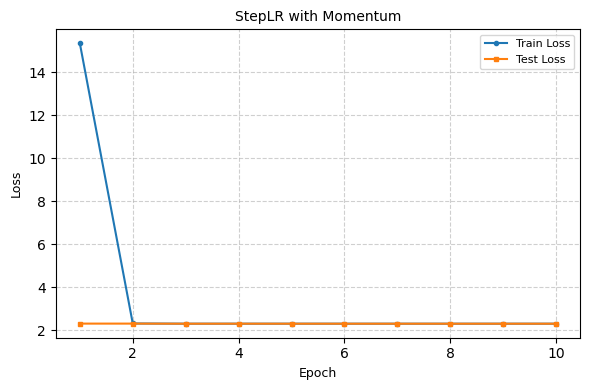

 Total Execution Time: 387.37 seconds
 Total Training Time: 351.69 seconds
 Average Time per Epoch: 35.17 seconds


In [31]:

# Example usage with StepLR scheduler
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 5, 7], gamma=0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs=10, scheduler=scheduler, save_name='stepLR_momentum.png', title = 'StepLR with Momentum')


# Changing dimension of batch

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9912422/9912422 [00:02<00:00, 3883977.53it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28881/28881 [00:00<00:00, 268325.83it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1648877/1648877 [00:00<00:00, 1930307.28it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309740
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.165435
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.081501
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.136877
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.025362
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.046573
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.003308
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.008992
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.031826
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.000440
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.003872
Train Epoch: 1 [44000/60000 (73%)]	Loss: 0.000519
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.124091
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.000441
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.001043
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.0518, Accuracy: 9827/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000476
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.0

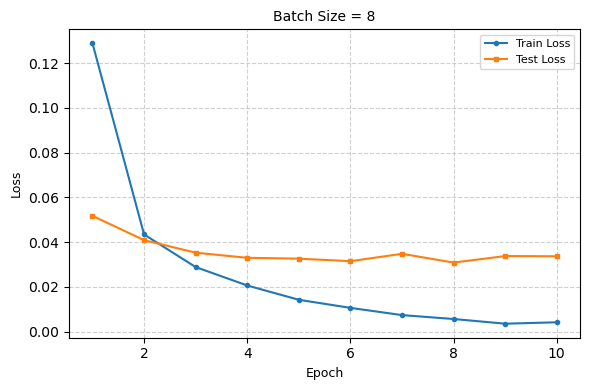

 Total Execution Time: 217.15 seconds
 Total Training Time: 173.67 seconds
 Average Time per Epoch: 17.37 seconds


In [32]:
device = torch.device("cuda") # to use the GPU
batch_size = 8

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('.data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='batch8', title = 'Batch Size = 8')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324349
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.135822
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.024868
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.037150
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.0677, Accuracy: 9782/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034704
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.172305
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.062939
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.003675
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.0449, Accuracy: 9851/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.034459
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.212261
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.042853
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.008960
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0414, Accuracy: 9854/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004667
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.059957
Train Epoch: 4 [32000/60000 (53%)]	Los

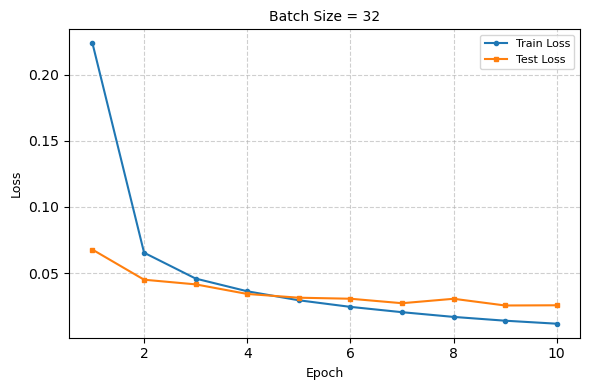

 Total Execution Time: 137.79 seconds
 Total Training Time: 99.59 seconds
 Average Time per Epoch: 9.96 seconds


In [33]:
device = torch.device("cuda") # to use the GPU
batch_size = 32

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='batch32', title = 'Batch Size = 32')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301270
Epoch 1, Learning Rate: 0.010000

Test set: Average loss: 0.1927, Accuracy: 9437/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.211908
Epoch 2, Learning Rate: 0.010000

Test set: Average loss: 0.1108, Accuracy: 9678/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.216134
Epoch 3, Learning Rate: 0.010000

Test set: Average loss: 0.0855, Accuracy: 9734/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.073275
Epoch 4, Learning Rate: 0.010000

Test set: Average loss: 0.0648, Accuracy: 9789/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.019869
Epoch 5, Learning Rate: 0.010000

Test set: Average loss: 0.0559, Accuracy: 9822/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.079286
Epoch 6, Learning Rate: 0.010000

Test set: Average loss: 0.0526, Accuracy: 9832/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.050256
Epoch 7, Learning Rate: 0.010000

Test set: Average loss: 0.0464, Accuracy: 9862/10000 (99%)

Train Epoch: 8 [0/60000 (0%

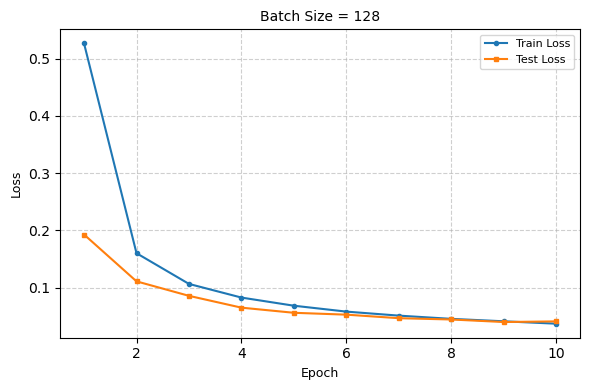

 Total Execution Time: 126.62 seconds
 Total Training Time: 91.99 seconds
 Average Time per Epoch: 9.20 seconds


In [34]:
device = torch.device("cuda") # to use the GPU
batch_size = 128

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs, save_name='batch128', title = 'Batch Size = 128')